# Introduction

### Connection with machine learning

Machine learning is used to describe basically anything these days, but here I am referring to methods based on neural networks.

<br>

<img src="https://imgs.xkcd.com/comics/machine_learning.png" width="350"/>

<br>

We can think about standard machine learning approaches as similar to **maximum likelihood estimation**. If we don't know what the likelihood looks like, or cannot come up with a functional form for it, we can choose to represent it as a matrix of unknown weights.

We can then *train* a neural network with simulated or labelled data in order to *learn* the appropriate weights, an optimisation process that can be thought of as maximising the likelihood. Once trained, the resulting matrix of weights can be used like an operator to return the maximum likelihood estimate for new input data. 

A key difference in this approach is that the likelihood itself is now a *black box*, and so **it is not so clear how we should interpret our model or the resulting inferences**. **The quantification of uncertainty is also not straightforward**. This is fine if you just want to make classifications or predictions, without asking why. That said, there is plenty of work being done on ways to interpret neural networks and methods exist to bring more Bayesian thinking in and allow uncertainty quantification. 

### Probability theory & Bayes' theorem

Let's start by recalling Bayes' theorem with data, $x$, and model parameters $\theta$:

<br>

<img src="figures/bayes_theorem.png" width="700"/>

<br>

### Markov Chain Monte Carlo (MCMC) Hamiltonian Monte Carlo

<br>

The goal in the implementation of any MCMC algorithm is the computation of expectation values. Consider a target sample space $Q$, of which any point $q \in Q$ can be parametrised by real numbers, in $D$ dimensions. In this parameter space, let our target distribution be a smooth density function, $\pi(q)$. 

<br>

Computing expectation values over this distribution is done by integrating over the parameter space

<br>

$$
\mathbb{E}_\pi[f] = \int_Q \mathrm{d}q~\pi(q)f(q).
$$

<br>

In practice, we approximate these integrals through the Markov chains returned by our samplers.

<br>

Given that we want to compute expectations, an obvious way for our sampler to be inefficient is to **waste time evaluating $\pi(q)$ in regions of parameter space that have negligible contribution to the expectation.**

<br>

So we should just focus on regions with large density, $\pi(q)$, right? *Not exactly*. The expectation is an *integral* of this density of the *volume*, $\mathrm{d}q$. While the density will be largest at the mode, there is relatively little volume here, especially in high dimensions. Recall the curse of dimensionality as illustrated in the figure below. The relative weight of a partition containing a point of interest decreases from $1/3$ to $1/9$ and $1/27$ as we scale from 1 to 3 dimensions.

<br>

<img src="figures/hmc1.png" width="700"/>

<br>

Actually, volume will be largest in the tails of the distribution, away from the mode. If we have $\pi(q)$ largest at the mode, and $\mathrm{d}q$ largest in the tails, the region of interest is somewhere between the two. Let's refer to this region as the **typical set**.

<br>

<img src="figures/hmc2.png" alt="The typical set" width="500"/>

<br>

So we have understood that we want to focus all our computational resources on exploring this typical set. As we discussed above, standard MCMC algorithms, such as the Metropolis-Hastings algorithm, will eventually explore the typical set, as long as the Markov transition *preserves* the target distribution. 

<br>

Given sufficient time, samples from the Markov chain can be used to approximate our desired expectations:

<br>

$$
\hat{f}_N = \frac{1}{N} \sum_{n=0}^N f(q_n),
$$
and
$$
\lim_{N\to\infty} \hat{f}_N = \mathbb{E}_\pi[f].
$$

MCMC samplers can be thought of as a guided random walk towards regions of high posterior density. This random walk behaviour is inherently **inefficient**. Model reparametrisation and other tricks can help to improve the situation, but the inefficiency remains, **especially in high-dimensional problems**.

<br>

**Hamiltonian Monte Carlo (HMC)** is a dramatically more efficient way to draw samples from the target posterior distribution, thanks to its departure from the random walk approach. Instead, HMC uses concepts from Hamiltonian mechanics to direct the Markov transitions and avoid diffusive behaviour.

<br>

So how can we explore the typical set more efficiently than with just randomly walking? We can exploit information about the *geometry* of the typical set, and use this to move through it. Imagine that we knew the *vector field* of the typical set, we could just follow it, like a ball rolling along a slope.

<br>

Great! But how can we find this vector field using only information about our target density? The *gradient* of the density will give us a vector field that points towards the mode, but we want to move around the mode in the typical set. We can imagine this as a physical system, like a satellite (our trajectory) in orbit around the Earth (the mode):

<br>

<img src="figures/hmc3.png" alt="Exploring the typical set" width="900"/>

<br>

We too can avoid "crashing into the mode" by giving our "satellite" enough momentum. But we don't want to add too much or too little momentum, either. 

<br>

We don't have time today to go into the details, but an excellent introduction to HMC that is suitable for researchers in the physical sciences can be found in [this paper](https://arxiv.org/pdf/1701.02434.pdf) by Michael Betancourt. Here I have just highlighted a few key points from this paper.

<u>Stan</u>

We will use the probabilistic programming language `Stan` in our examples to implement Hamiltonian Monte Carlo. In particular, we will use the python interface to `Stan` called `cmdstanpy`. Here, I introduce a simple example of using `cmdstanpy` to fit the mean and width of a Normal distribution from a set of normally distributed data.

In [1]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from cmdstanpy import CmdStanModel
import arviz as av

Text(0.5, 0, 'x')

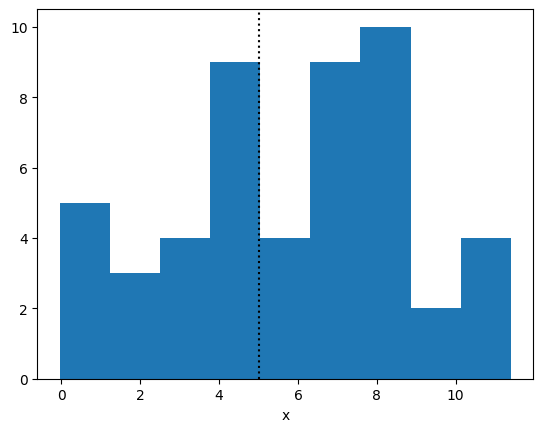

In [2]:
# simulate some data from a normal distribution
N = 50
mu = 5
sigma = 3
x = stats.norm(loc=mu, scale=sigma).rvs(N)

# plot histogram
fig, ax = plt.subplots()
ax.hist(x, bins=np.linspace(min(x), max(x), 10))
ax.axvline(mu, color="k", linestyle=":")
ax.set_xlabel("x")

To fit this data with Stan to try and recover `mu` and `sigma`, we need to write our model in the Stan language. More details can be found in the [Stan user's guide](https://mc-stan.org/docs/2_27/stan-users-guide/index.html). The model for normal-distributed data looks like this:

```cpp
data{
    int N;
    vector[N] x;
}

parameters { 
    real mu;
    real<lower=0> sigma;
}

model {
    x ~ normal(mu, sigma);
}
```
>NB: by not specifying priors on the parameters `mu` and `sigma`, we implicitly define uniform priors over +/- infinity, or within the bounds given by `<lower=L, upper=U>`. 

You can find this model in the file `stan/normal.stan`. 

In [3]:
# compile the Stan model
stan_model = CmdStanModel(stan_file="stan/normal.stan")

print(stan_model)

CmdStanModel: name=normal
	 stan_file=/Users/Capel/projects/TAML-stats/stan/normal.stan
	 exe_file=/Users/Capel/projects/TAML-stats/stan/normal
	 compiler_options=stanc_options={}, cpp_options={}


In [4]:
# put data in dict to pass to the CmdStanModel
# the keys have to match the variable names in the Stan file data block
data = {}
data["N"] = N
data["x"] = x

# run HMC for 1000 iterations with 4 chains
fit = stan_model.sample(data=data, iter_sampling=1000, chains=4)

# check the results
fit.summary()

16:37:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:37:35 - cmdstanpy - INFO - CmdStan done processing.
16:37:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/Capel/projects/TAML-stats/stan/normal.stan', line 12, column 4 to column 26)
Consider re-running with show_console=True if the above output is unclear!


,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,R_hat
lp__,-80.12970,0.025392,1.061010,0.754643,-82.21410,-79.80250,-79.13870,1716.43,2331.18,1.00124
mu,5.73861,0.007630,0.452910,0.449591,5.01209,5.73691,6.48771,3525.63,2383.34,1.00056
sigma,3.13561,0.005906,0.331089,0.304926,2.64944,3.09909,3.73292,3281.48,2341.04,1.00248


In [5]:
# check diagnostics
print(fit.diagnose())

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

Rank-normalized split R-hat values satisfactory for all parameters.

Processing complete, no problems detected.



5.738608382500001
(4000,)


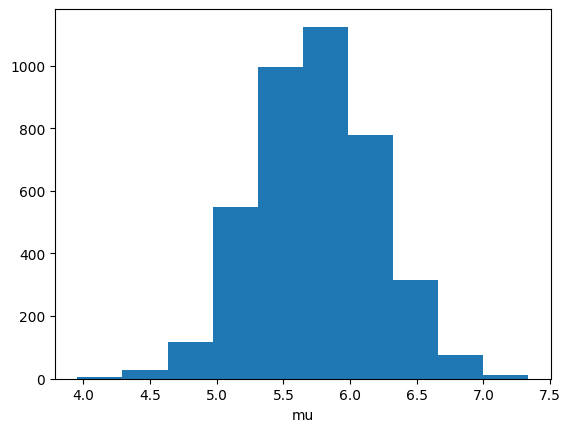

In [6]:
# access parameter chains
mu_chain = fit.stan_variable("mu")

fig, ax = plt.subplots()
ax.hist(mu_chain)
ax.set_xlabel("mu")

print(np.mean(mu_chain))
print(np.shape(mu_chain)) # 1000 iterations x 4 chains

In [7]:
# access all parameter chains in dict
fit.stan_variables()

{'mu': array([5.28584, 5.88879, 5.88879, ..., 5.6362 , 5.86517, 5.39718],
       shape=(4000,)),
 'sigma': array([3.55848, 2.91938, 2.91938, ..., 3.02543, 3.15647, 3.23317],
       shape=(4000,))}

In [8]:
# access all chains and sample info
# e.g. lp__: log posterior value
# Don't worry too much about all the names with underscores__
fit.draws_pd()

,chain__,iter__,draw__,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu,sigma
0,1.0,1.0,1.0,-80.5744,0.893600,0.949852,2.0,3.0,0.0,81.2882,5.28584,3.55848
1,1.0,2.0,2.0,-79.2360,0.949483,0.949852,2.0,3.0,0.0,81.2741,5.88879,2.91938
2,1.0,3.0,3.0,-79.2360,0.774443,0.949852,1.0,3.0,0.0,80.4339,5.88879,2.91938
3,1.0,4.0,4.0,-79.5988,0.932102,0.949852,2.0,3.0,0.0,79.8948,5.36511,2.92289
4,1.0,5.0,5.0,-79.6865,0.970364,0.949852,2.0,3.0,0.0,80.2335,6.02292,2.80322
...,...,...,...,...,...,...,...,...,...,...,...,...
3995,4.0,996.0,3996.0,-80.4989,0.493242,0.966261,2.0,3.0,0.0,82.7554,5.01233,3.14825
3996,4.0,997.0,3997.0,-79.5708,1.000000,0.966261,1.0,1.0,0.0,80.3131,5.32064,3.08454
3997,4.0,998.0,3998.0,-79.1214,1.000000,0.966261,1.0,3.0,0.0,79.5066,5.63620,3.02543
3998,4.0,999.0,3999.0,-79.1807,0.927894,0.966261,2.0,3.0,0.0,79.5955,5.86517,3.15647


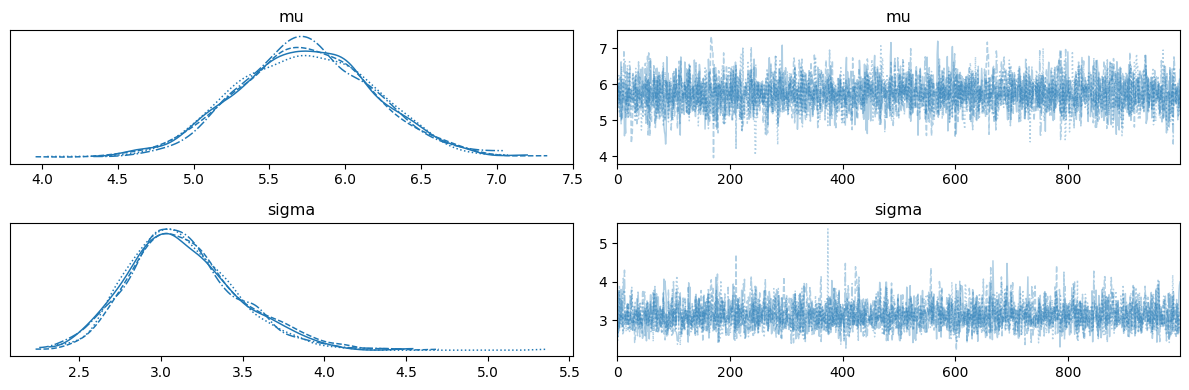

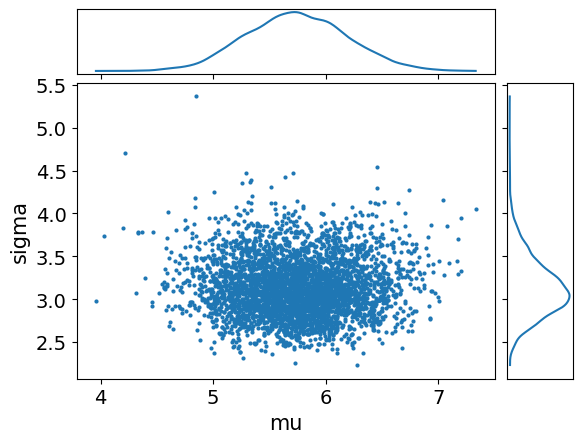

In [9]:
# use arviz to visualise the results if you like, it has common functionality built in
ax = av.plot_trace(fit);
fig = ax[0,0].get_figure()
fig.tight_layout()

av.plot_pair(fit, marginals=True);

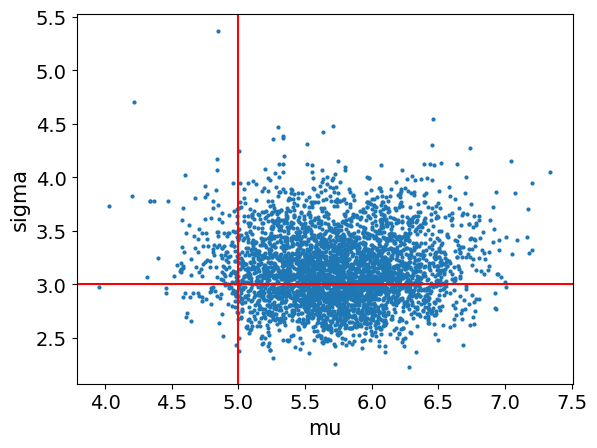

In [10]:
# the av.plot.. calls return an axis that you can continue plotting on
ax = av.plot_pair(fit, var_names=["mu", "sigma"])
ax.axvline(mu, color="r")
ax.axhline(sigma, color="r")

<Axes: xlabel='mu', ylabel='sigma'>

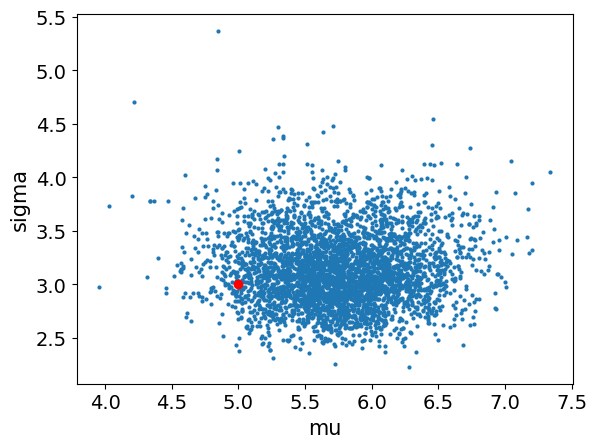

In [11]:
# or you can pass them an axis
fig, ax = plt.subplots()
ax.scatter(mu, sigma, color="r")
av.plot_pair(fit, var_names=["mu", "sigma"], ax=ax)

Ok, so it looks like everything is up and running. You can try changing the input data and see how the results change accordingly. Let's investigate a few specific cases in the exercise below.

<br>

**Exercise 1.1:** 

What happens to the shape of the marginal distributions in the following cases: 

* Very little data (small `N`) 
* Large amounts of data (large `N`)
* Narrow priors on `mu` and `sigma`

Make plots to summarise the comparison with the original case. What differences can be seen with what we might expect from a point estimate of these parameters using e.g. maximum likelihood.

<span style="color:green">**Exercise 1.1 solution**</span>

<span style="color:green">First let's compare different sample sizes.</span>

In [12]:
N = [1, 5, 50, 1000]
fits = []

for n in N:
    x = stats.norm(loc=mu, scale=sigma).rvs(n)
    data = {}
    data["N"] = n
    data["x"] = x
    fit = stan_model.sample(data=data, iter_warmup=1000, iter_sampling=1000, chains=4)
    fits.append(fit)

16:37:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:37:36 - cmdstanpy - INFO - CmdStan done processing.
16:37:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/Capel/projects/TAML-stats/stan/normal.stan', line 12, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/Capel/projects/TAML-stats/stan/normal.stan', line 12, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/Capel/projects/TAML-stats/stan/normal.stan', line 12, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/Capel/projects/TAML-stats/stan/normal.stan', line 12, column 4 to column 26)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/Capel/projects/TAML-stats/stan/normal.stan', line 12, column 4 to column 26)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/Capel/proj

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:37:36 - cmdstanpy - INFO - CmdStan done processing.
16:37:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:37:36 - cmdstanpy - INFO - CmdStan done processing.


16:37:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:37:36 - cmdstanpy - INFO - CmdStan done processing.


<span style="color:green">We should notice that extremely low sample numbers lead to issues with sampling, this just reflects that it is difficult to estimate the mean of a distribution based on so little information. Note that we also didn't provide any priors...</span>

In [13]:
print(fits[0].diagnose())
fits[0].summary()

Checking sampler transitions treedepth.
34 of 1000 (3.40%) transitions hit the maximum treedepth limit of 10, or 2^10 leapfrog steps.
Trajectories that are prematurely terminated due to this limit will result in slow exploration.
For optimal performance, increase this limit.

Checking sampler transitions for divergences.
3875 of 1000 (387.50%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

The following parameters had rank-normalized split R-hat greater than 1.01:
  mu
Such high values indicate incomplete mixing and biased estimation.
You should consider regularizating your model with additional prior information or a more ef

,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,R_hat
lp__,-5.959000e-05,NaN,1.322450e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN
mu,-2.236980e+12,2.717730e+12,4.522190e+12,9.240770e+11,-1.304660e+13,-2.285880e+11,9.575340e+11,5.57681,2000.00,1.93558
sigma,inf,inf,inf,1.031330e+156,6.319540e+25,6.956240e+155,4.517800e+292,810.56800,1036.89,1.01183


Text(0.5, 0, 'sigma')

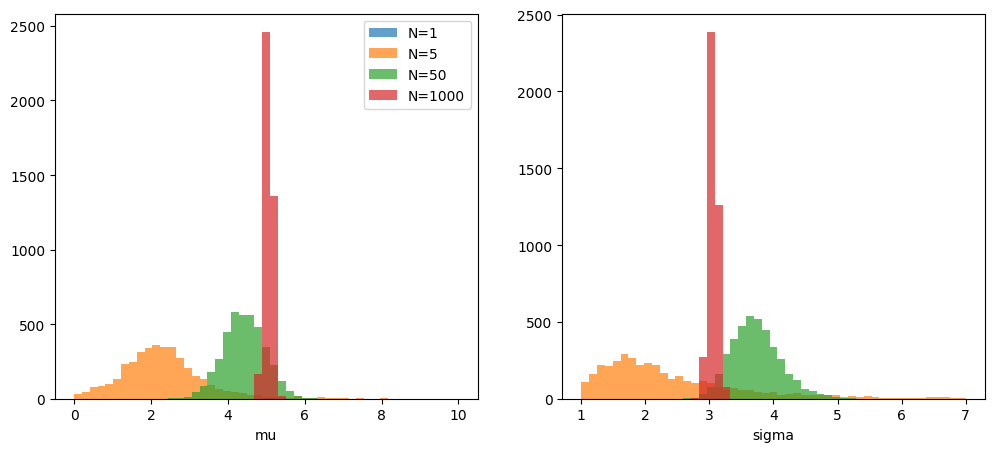

In [14]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches((12, 5))

bins_mu = np.linspace(0, 10)
bins_sigma = np.linspace(1, 7)

for n, fit in zip(N, fits):
    ax[0].hist(fit.stan_variable("mu"), bins=bins_mu, alpha=0.7, label="N=%i"%n)
    ax[1].hist(fit.stan_variable("sigma"), bins=bins_sigma, alpha=0.7, label="N=%i"%n)

ax[0].legend()
ax[0].set_xlabel("mu")
ax[1].set_xlabel("sigma")

<span style="color:green">So we see that increasing the amount of data clearly leads to tighter constraints of the values of the parameters that we want to estimate. It is intuitive that with less information there is more uncertainty. The factor would be less obvious if we were just using a point estimate, such as the maximum likelihood estimate. Next, let's consider some narrow priors. Let's take two cases: narrow priors centred on true values, and narrow priors centred elsewhere (see Stan files for details). In both cases, we can use N=50 to compare with our original case of implicit uniform priors.</span>

In [15]:
stan_files = ["stan/normal.stan", "stan/normal_prior_true.stan",
              "stan/normal_prior_false.stan"]
N = 50
data = {}
data["N"] = N
data["x"] = stats.norm(loc=mu, scale=sigma).rvs(N)

fits = []
for sf in stan_files:
    stan_model = CmdStanModel(stan_file=sf)
    fit = stan_model.sample(data=data, iter_sampling=1000, chains=4)
    fits.append(fit)

16:37:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:37:37 - cmdstanpy - INFO - CmdStan done processing.
16:37:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:37:37 - cmdstanpy - INFO - CmdStan done processing.
16:37:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:37:38 - cmdstanpy - INFO - CmdStan done processing.


Text(0.5, 0, 'sigma')

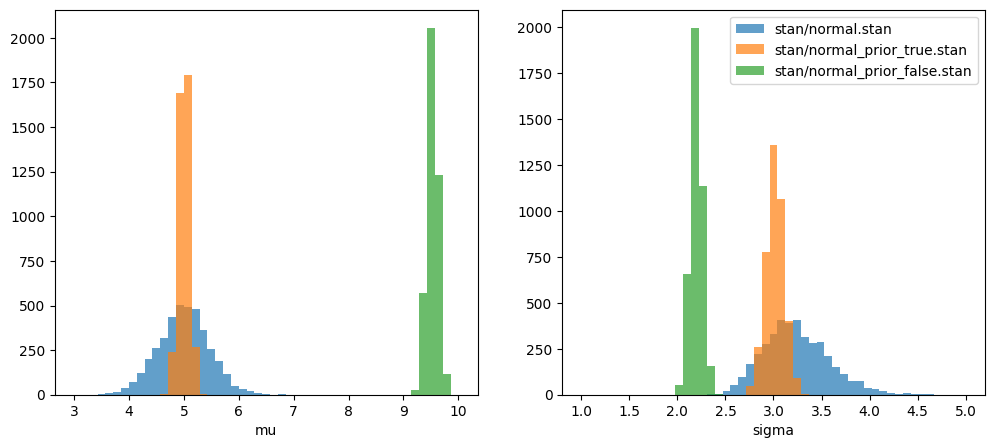

In [16]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 5)

bins_mu = np.linspace(3, 10)
bins_sigma = np.linspace(1, 5)

for sf, fit in zip(stan_files, fits):
    ax[0].hist(fit.stan_variable("mu"), bins=bins_mu, alpha=0.7, label=sf)
    ax[1].hist(fit.stan_variable("sigma"), bins=bins_sigma, alpha=0.7, label=sf)
ax[1].legend()
ax[0].set_xlabel("mu")
ax[1].set_xlabel("sigma")

	
<span style="color:green">Similar to how data brings in information to a model, the prior also brings in information. We see that adding information that helps us to find the true value leads to a dramatic reduction in uncertainty. However, a poor choice of prior can lead use to a confident conclusion on completely the wrong result! We should make sensible prior choices that reflect what we know about the problem, and keep our prior assumptions in mind when analysing the results. Standard point estimate approaches such as maximum likelihood do not involve priors in any way, so information cannot be added in this way.</span>

### Some more fun with Stan

Let's consider a simple linear regression problem. We observe a variable $y$ that is related to a known quantity $x$ via
$$
y = mx + c,
$$
where $m$ and $c$ are the unknown slope and intercept, to be determined. Our observation process introduces uncertainty, such that 
$$
\hat{y} \sim \mathcal{N}(y, \sigma),
$$
where $\sigma$ is a known quantity that is constant for all observations.


**Exercise 1.2:** Write a Stan model for the above model, considering the dataset introduced below. Verify that it compiles, pass the data to Stan and fit the model. 

Text(0, 0.5, 'y')

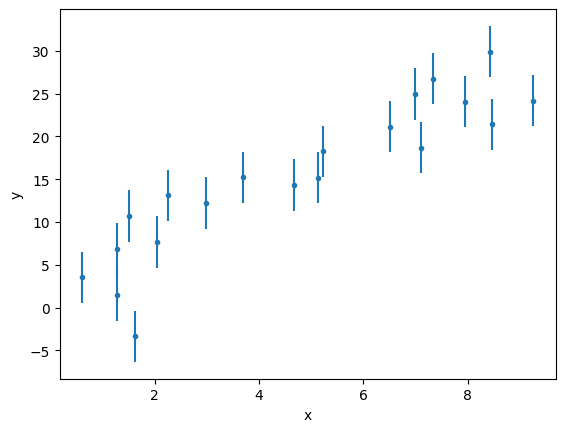

In [17]:
# load data
data = np.loadtxt("data/linear.dat")
x_obs = data[0]
y_obs = data[1]
sigma = data[2][0] # all the same

# plot
fig, ax = plt.subplots()
ax.errorbar(x_obs, y_obs, yerr=sigma, fmt=".")
ax.set_xlabel("x")
ax.set_ylabel("y")

<span style="color:green">**Exercise 1.2 solution:**</span>

In [18]:
!cat stan/line_fit.stan

data{

  int N;
  vector[N] x_obs;
  vector[N] y_obs;
  real sigma;
}

parameters { 

  real m;
  real c;

}

transformed parameters {

  vector[N] y;

  y = m * x_obs + c;
  
}

model {
  
  y_obs ~ normal(y, sigma);

}


In [19]:
data = {}
data["N"] = len(x_obs)
data["x_obs"] = x_obs
data["y_obs"] = y_obs
data["sigma"] = sigma

stan_model = CmdStanModel(stan_file="stan/line_fit.stan")
fit = stan_model.sample(data=data, iter_sampling=1000, chains=4)

16:37:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:37:38 - cmdstanpy - INFO - CmdStan done processing.


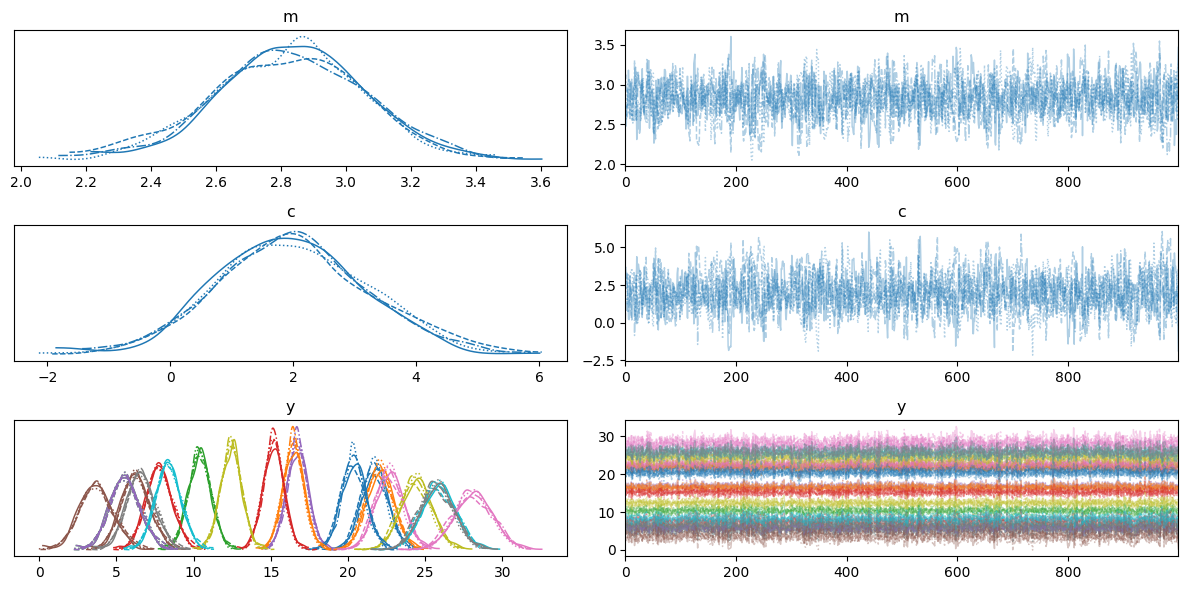

In [20]:
ax = av.plot_trace(fit)
fig = ax[0,0].get_figure()
fig.tight_layout()

### A more realistic example: fitting a spectrum

Let's imagine that we have a simple particle detector that indirectly reconstructs the true energy of the particle. Our data will be complicated by a number of "detector effects" that we will need to take into account in order to extract the true underlying spectrum.

<br>

Via this toy example, implemented in the `instrument_response` package, we will briefly cover the following topics:
* Forward folding 
* Goodness of fit
* Systematic uncertainties
